In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/suryasadasivam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suryasadasivam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd 
import openai 
import matplotlib.pyplot as plt
import os 
import re
import matplotlib.image as mping 
from matplotlib import table 
import chromadb
import json
import string 
from PIL import Image
from io import BytesIO
from pathlib import Path
from operator import itemgetter
import tiktoken
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#Importing the cross encoder library 
from sentence_transformers import CrossEncoder,util
# Importing required functions and classes from chromaDB
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

/Users/suryasadasivam/DataScience /project/RAG_recommendation_system/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
fashion_df=pd.read_csv("data/Fashion Dataset v2.csv")

fashion_df.head()

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products   price     colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0     Orange    InWeave   
2               Kurta, Trousers, Dupatta  4899.0  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta  3699.0        Red       Nayo   
4                                  Kurta  1350.0      Black      AHIKA   

                                                 img  ratingCount  avg_rating  \
0  http://assets.myntassets.com/assets/images/170...       4522.0    4.418399   
1  http://assets.myntassets.com/assets/images/165...       1081.0    4.119334   
2  http://assets.myntassets.com/assets/images/163...       1752.0    4.161530   
3  http://assets.myntassets.com/assets/images/147...       4113.0    4.088986   
4  http://assets.myntassets.com/assets/images/110...      21274.0    3.978377   

                                         description  \
0  Black printed Kurta with Palazzos with dupatta...   
1  Orange solid Kurta with Palazzos with dupatta<...   
2  Navy blue embroidered Kurta with Trousers with...   
3  Red printed kurta with trouser and dupatta<br>...   
4  Black and green printed straight kurta, has a ...   

                                        p_attributes  
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
4  {'Body Shape ID': '424', 'Body or Garment Size...

We can ignore 'img' column since it contains _URI_ for the product image which is already available in _'data/images'_ folder with the file name given in `'p_id'` column.

In [4]:
# Remmoving the "img" column from the Fashion Dataframe to exclude image data. 

fashion_df=fashion_df.drop(columns=['img'])

fashion_df.head()

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products   price     colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0     Orange    InWeave   
2               Kurta, Trousers, Dupatta  4899.0  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta  3699.0        Red       Nayo   
4                                  Kurta  1350.0      Black      AHIKA   

   ratingCount  avg_rating                                        description  \
0       4522.0    4.418399  Black printed Kurta with Palazzos with dupatta...   
1       1081.0    4.119334  Orange solid Kurta with Palazzos with dupatta<...   
2       1752.0    4.161530  Navy blue embroidered Kurta with Trousers with...   
3       4113.0    4.088986  Red printed kurta with trouser and dupatta<br>...   
4      21274.0    3.978377  Black and green printed straight kurta, has a ...   

                                        p_attributes  
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
4  {'Body Shape ID': '424', 'Body or Garment Size...

In [5]:
fashion_df.description[0]

"Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  </b> <ul> <li> Ethnic motifs printed </li> <li> Anarkali shape </li> <li> Regular style </li> <li> Mandarin collar,  three-quarter regular sleeves </li> <li> Calf length with flared hem </li> <li> Viscose rayon machine weave fabric </li> </ul> <br> <b> Palazzos design:  </b> <ul> <li> Printed Palazzos </li> <li> Elasticated waistband </li> <li> Slip-on closure </li> </ul>Dupatta Length 2.43 meters Width:&nbsp;88 cm<br>The model (height 5'8) is wearing a size S100% Rayon<br>Machine wash"

In [6]:
# Define a function to remove HTML tags from the input string.

def remove_html_tag(html_string):
    #Regular expression for the pattern match
    pattern=re.compile(r'<.*?>')

    string=re.sub(pattern," ", html_string)

    #print(f"first print  {string}")
    
    string=string.split(" ")

    #print(f"second print {string}")

    string=list(filter(lambda x:x != "",string))

    #print(f"third print {string}")

    string= " ".join(string)

    return string


In [7]:
remove_html_tag(fashion_df.description[0])

"Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs printed Anarkali shape Regular style Mandarin collar, three-quarter regular sleeves Calf length with flared hem Viscose rayon machine weave fabric Palazzos design: Printed Palazzos Elasticated waistband Slip-on closure Dupatta Length 2.43 meters Width:&nbsp;88 cm The model (height 5'8) is wearing a size S100% Rayon Machine wash"

In [8]:
fashion_df['cleaned_description']=fashion_df['description'].apply(lambda x: remove_html_tag(x))

fashion_df.head()

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products   price     colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0     Orange    InWeave   
2               Kurta, Trousers, Dupatta  4899.0  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta  3699.0        Red       Nayo   
4                                  Kurta  1350.0      Black      AHIKA   

   ratingCount  avg_rating                                        description  \
0       4522.0    4.418399  Black printed Kurta with Palazzos with dupatta...   
1       1081.0    4.119334  Orange solid Kurta with Palazzos with dupatta<...   
2       1752.0    4.161530  Navy blue embroidered Kurta with Trousers with...   
3       4113.0    4.088986  Red printed kurta with trouser and dupatta<br>...   
4      21274.0    3.978377  Black and green printed straight kurta, has a ...   

                                        p_attributes  \
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...   
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...   
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...   
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...   
4  {'Body Shape ID': '424', 'Body or Garment Size...   

                                 cleaned_description  
0  Black printed Kurta with Palazzos with dupatta...  
1  Orange solid Kurta with Palazzos with dupatta ...  
2  Navy blue embroidered Kurta with Trousers with...  
3  Red printed kurta with trouser and dupatta Kur...  
4  Black and green printed straight kurta, has a ...

### Data Visualization

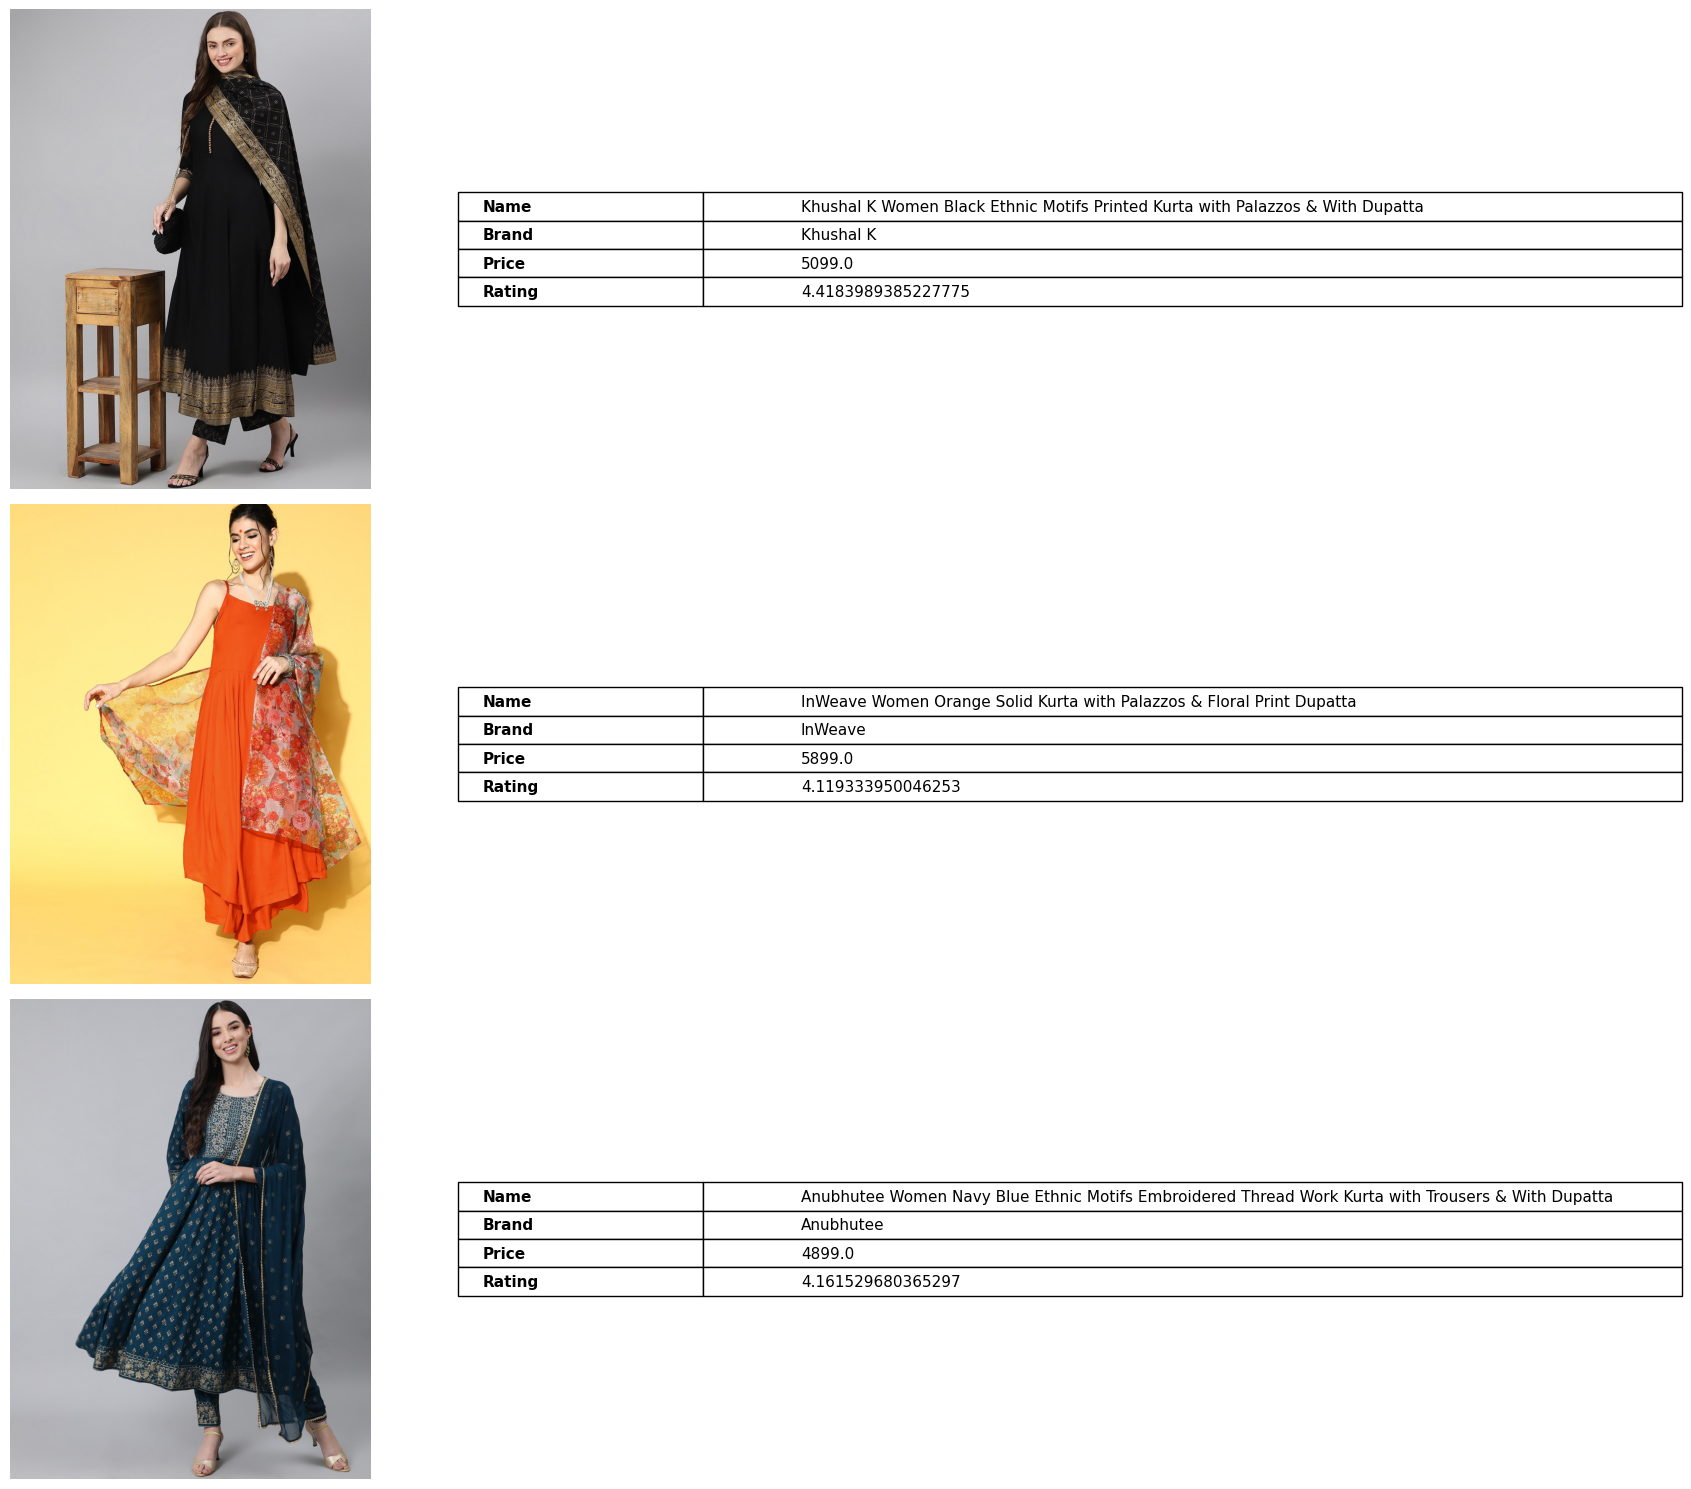

In [9]:
from PIL import Image,UnidentifiedImageError

images_folder_path='data/Images'

def display_image_with_info(df,images_folder_path, num_images=3):

    # create a subplots to display images and mini tables 
    fig,axes=plt.subplots(num_images,2,figsize=(20,num_images*5))

    #displayed image tracking 
    images_displayed=0

    for i, (idx,row)in enumerate(df.iterrows()):
        #construct the path to the image file 
        image_path=os.path.join(images_folder_path,str(row['p_id'])+'.jpg')

        #check if the file exists 
        if os.path.exists(image_path):
            try:
                img=Image.open(image_path)
                #display the image 
                axes[images_displayed,0].imshow(img)
                axes[images_displayed,0].axis('off')

                #create a mini table with information  from df 
                table_data=[["Name",row['name']],
                            ["Brand",row["brand"]],
                            ["Price",row["price"]],
                            ["Rating",row["avg_rating"]]
                            ]
                axes[images_displayed,1].axis('off')
                mini_table=axes[images_displayed,1].table(cellText=table_data,loc='center',cellLoc='left',colWidths=[0.2,0.8])

                #format th minitable 

                for cell in mini_table.get_celld().values():
                    if cell.get_text().get_text()in["Name","Brand","Price","Rating"]:
                        cell.get_text().set_fontweight('bold')
                    cell.get_text().set_fontsize(12)
                
                #set font size explicitly for all cells
                mini_table.auto_set_font_size(False)
                mini_table.set_fontsize(11)
                mini_table.scale(1.2,1.2) #Adjust the scaling factor as needed

                images_displayed+=1

                #Increment the count of displayed images 
                if images_displayed>=num_images:
                    break 
            except UnidentifiedImageError:
                print(f'unable to opne image: {image_path}')
        else:
            print(f"image not found:{image_path}")
    plt.tight_layout()
    plt.show()


display_image_with_info(fashion_df,images_folder_path,num_images=3)



    

### Metadata Preparation

- The product information is currently fragmented across various columns, hindering comprehensive keyword searches.
- Since our query focuses solely on documents, this fragmentation poses limitations.
<br>

- There are two solutions:
    - *Option 1*: Centralize all the product details as metadata. Develop a chatbot to extract metadata values, facilitating precise filtering. Utilize the filtered results to construct a RAG model.
    - *Option 2*: Compile a cohesive document called as 'metadata' incorporating all product details. Load this document entirely into the document section of the vector DB. This ensures vector DB is aware of additional keywords used in user queries.
    
> For the present task, I opted for option 2 for enhanced efficiency.

In [10]:
#convert the data to a dictionary format with meta data

fashion_df["metadata"]=fashion_df.apply(
    lambda x:{
        'Product_id': x['p_id'],  # Unique identifier for the product
        'Name': x['name'],  # Product name
        'Product_type': x['products'],  # Type or category of the product
        'Price_INR': x['price'],  # Price of the product in Indian Rupees
        'Colour': x['colour'],  # Color of the product
        'Brand': x['brand'],  # Brand of the product
        'RatingCount': x['ratingCount'],  # Number of ratings received
        'Rating': x['avg_rating'],  # Average rating of the product
        'Description': x['cleaned_description'],  # Description of the product
        'Product_attributes': x['p_attributes']  # Additional attributes of the product
        }, axis=1
)

# Display the first few rows of the modified DataFrame.
fashion_df.head()

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products   price     colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0     Orange    InWeave   
2               Kurta, Trousers, Dupatta  4899.0  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta  3699.0        Red       Nayo   
4                                  Kurta  1350.0      Black      AHIKA   

   ratingCount  avg_rating                                        description  \
0       4522.0    4.418399  Black printed Kurta with Palazzos with dupatta...   
1       1081.0    4.119334  Orange solid Kurta with Palazzos with dupatta<...   
2       1752.0    4.161530  Navy blue embroidered Kurta with Trousers with...   
3       4113.0    4.088986  Red printed kurta with trouser and dupatta<br>...   
4      21274.0    3.978377  Black and green printed straight kurta, has a ...   

                                        p_attributes  \
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...   
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...   
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...   
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...   
4  {'Body Shape ID': '424', 'Body or Garment Size...   

                                 cleaned_description  \
0  Black printed Kurta with Palazzos with dupatta...   
1  Orange solid Kurta with Palazzos with dupatta ...   
2  Navy blue embroidered Kurta with Trousers with...   
3  Red printed kurta with trouser and dupatta Kur...   
4  Black and green printed straight kurta, has a ...   

                                            metadata  
0  {'Product_id': 17048614, 'Name': 'Khushal K Wo...  
1  {'Product_id': 16524740, 'Name': 'InWeave Wome...  
2  {'Product_id': 16331376, 'Name': 'Anubhutee Wo...  
3  {'Product_id': 14709966, 'Name': 'Nayo Women R...  
4  {'Product_id': 11056154, 'Name': 'AHIKA Women ...

In [11]:
fashion_df["metadata"].iloc[0]

{'Product_id': 17048614,
 'Name': 'Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta',
 'Product_type': 'Kurta, Palazzos, Dupatta',
 'Price_INR': 5099.0,
 'Colour': 'Black',
 'Brand': 'Khushal K',
 'RatingCount': 4522.0,
 'Rating': 4.4183989385227775,
 'Description': "Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs printed Anarkali shape Regular style Mandarin collar, three-quarter regular sleeves Calf length with flared hem Viscose rayon machine weave fabric Palazzos design: Printed Palazzos Elasticated waistband Slip-on closure Dupatta Length 2.43 meters Width:&nbsp;88 cm The model (height 5'8) is wearing a size S100% Rayon Machine wash",
 'Product_attributes': "{'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'Slip-On', 'Bottom Fabric': 'Viscose Rayon', 'Bottom Pattern': 'Printed', 'Bottom Type': 'Palazzos', 'Character': 'NA', 'Dupatta': 'With Dupatta', '

### Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the metadata in the dataframe through OpenAI's text-embedding-ada-002 model, and store them in a ChromaDB collection.

In [ ]:
#set the api key for openAI

openai.api_key="add your open api key here"

In [13]:
#define the path for storing ChromaDB collections
chroma_data_path="./ChromaDB_Data"

#intialize the chromdb client with the specific path 
client = chromadb.PersistentClient(path=chroma_data_path)

# 🔌 Set up the embedding function using OpenAI
embedding_function = OpenAIEmbeddingFunction(
    api_key=openai.api_key,
    model_name="text-embedding-ada-002"
)

In [14]:
fashion_df["metadata"].iloc[0]

{'Product_id': 17048614,
 'Name': 'Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta',
 'Product_type': 'Kurta, Palazzos, Dupatta',
 'Price_INR': 5099.0,
 'Colour': 'Black',
 'Brand': 'Khushal K',
 'RatingCount': 4522.0,
 'Rating': 4.4183989385227775,
 'Description': "Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs printed Anarkali shape Regular style Mandarin collar, three-quarter regular sleeves Calf length with flared hem Viscose rayon machine weave fabric Palazzos design: Printed Palazzos Elasticated waistband Slip-on closure Dupatta Length 2.43 meters Width:&nbsp;88 cm The model (height 5'8) is wearing a size S100% Rayon Machine wash",
 'Product_attributes': "{'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'Slip-On', 'Bottom Fabric': 'Viscose Rayon', 'Bottom Pattern': 'Printed', 'Bottom Type': 'Palazzos', 'Character': 'NA', 'Dupatta': 'With Dupatta', '

In [15]:
#function to extract_text for embedding

def extract_text(metadata):

    text_content= ""
    if "Description" in metadata and metadata["Description"]:
        text_content+=metadata["Description"] #add product description
    if "Name" in metadata:
        text_content+= " "+ metadata["Name"] #add product name 
    if not text_content:
        text_content= "No description available"
    return text_content.strip() #strip leading and trailing white space 


In [16]:
fashion_df.head(1)

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   

                   products   price colour      brand  ratingCount  \
0  Kurta, Palazzos, Dupatta  5099.0  Black  Khushal K       4522.0   

   avg_rating                                        description  \
0    4.418399  Black printed Kurta with Palazzos with dupatta...   

                                        p_attributes  \
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...   

                                 cleaned_description  \
0  Black printed Kurta with Palazzos with dupatta...   

                                            metadata  
0  {'Product_id': 17048614, 'Name': 'Khushal K Wo...

In [ ]:
document =[extract_text(row['metadata']) for _, row in fashion_df.head(1000).iterrows()]

#get or create a chromaDB collection for fashion products 
fashion_collection=client.get_or_create_collection(name="Fashion_Products",embedding_function=embedding_function)

#Add data to chromaDB collection
subset_df = fashion_df.head(1000)
for idx, (p_id,metadata) in enumerate(zip(subset_df['p_id'],subset_df["metadata"])):
    fashion_collection.add(
        documents=[document[idx]],
        ids=[str(p_id)],
        metadatas=[metadata]

    )
print("Data Added to chromaDB collection")

IndexError: list index out of range

In [21]:
total_records = fashion_collection.count()
print(f"Total records in the collection: {total_records}")


Total records in the collection: 1000


In [27]:
peeked_data = fashion_collection.peek(1012)
print(len(peeked_data['ids']))

1000


In [28]:
fashion_collection.peek(1)

{'ids': ['17048614'],
 'embeddings': array([[-0.02296126, -0.00022818,  0.02090184, ...,  0.00910694,
          0.00190898, -0.01449622]], shape=(1, 1536)),
 'documents': ["Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs printed Anarkali shape Regular style Mandarin collar, three-quarter regular sleeves Calf length with flared hem Viscose rayon machine weave fabric Palazzos design: Printed Palazzos Elasticated waistband Slip-on closure Dupatta Length 2.43 meters Width:&nbsp;88 cm The model (height 5'8) is wearing a size S100% Rayon Machine wash Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta"],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': [{'Product_id': 17048614,
   'Brand': 'Khushal K',
   'Product_attributes': "{'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'Slip-On', 'Bottom Fabric': 'Viscose Rayo

---
<a id='layer2'></a>
## Layer 2 : Search & Rank Layer

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [29]:
#specify the name for the cache collection

cache_collection_name="Fashion_Cache"

##get or create a cache  collection for fashion search using the persistent client
cache_collection=client.get_or_create_collection(name=cache_collection_name,embedding_function=embedding_function)

#display a preview of the cache collection to inspect its contents
cache_collection.peek()


{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': []}

In [51]:
#display a preview of the cache collection to inspect its contents
cache_collection.peek()

{'ids': ['red kurta'],
 'embeddings': array([[-0.01241937, -0.00488691,  0.01018802, ..., -0.00050773,
         -0.00462302, -0.00656042]], shape=(1, 1536)),
 'documents': ['red kurta'],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': [{'included8': 's',
   'ids1': '12834498',
   'ids2': '3084524',
   'metadatas3': '{\'Brand\': \'Vishudh\', \'Product_attributes\': "{\'Add-Ons\': \'Jacket\', \'Body Shape ID\': \'333,424\', \'Body or Garment Size\': \'Garment Measurements in\', \'Bottom Closure\': \'Slip-On\', \'Bottom Fabric\': \'Viscose Rayon\', \'Bottom Pattern\': \'Solid\', \'Bottom Type\': \'Trousers\', \'Character\': \'NA\', \'Dupatta\': \'NA\', \'Dupatta Border\': \'NA\', \'Dupatta Fabric\': \'NA\', \'Dupatta Pattern\': \'NA\', \'Main Trend\': \'Pastels\', \'Neck\': \'Round Neck\', \'Number of Pockets\': \'NA\', \'Occasion\': \'Festive\', \'Ornamentation\': \'Thread Work\', \'Pattern Coverage\': \'Yoke or Border\', \'Print or Patt

In [125]:
total_records_cache= cache_collection.count()
total_records_cache

2

In [129]:
cache_collection.peek(1)

{'ids': ['red kurta'],
 'embeddings': array([[-0.01241937, -0.00488691,  0.01018802, ..., -0.00050773,
         -0.00462302, -0.00656042]], shape=(1, 1536)),
 'documents': ['red kurta'],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': [{'distances2': '0.2112622708082199',
   'metadatas1': '{\'Brand\': \'Meeranshi\', \'Price_INR\': 2199.0, \'Product_type\': \'Kurta\', \'Name\': \'Meeranshi Women Pink & Golden Printed Straight Dyed Kurta\', \'Product_attributes\': "{\'Body Shape ID\': \'424\', \'Body or Garment Size\': \'Garment Measurements in\', \'Colour Family\': \'Bright\', \'Design Styling\': \'Regular\', \'Fabric\': \'Viscose Rayon\', \'Fabric 2\': \'NA\', \'Fabric Purity\': \'Synthetic\', \'Hemline\': \'Straight\', \'Length\': \'Calf Length\', \'Main Trend\': \'NA\', \'Neck\': \'Round Neck\', \'Number of Pockets\': \'NA\', \'Occasion\': \'Festive\', \'Ornamentation\': \'NA\', \'Pattern\': \'Printed\', \'Print or Pattern Type\': \'

In [32]:
#prompt the user to enter a fashion_related query with specific requriements

query=input("please enter your query:")

In [31]:
query

'red kurta'

In [33]:
# Search the Cache collection first

cache_results = cache_collection.query(
    query_texts=query,  # User query
    n_results=5  # Number of results to retrieve
)
cache_results

{'ids': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[]],
 'distances': [[]]}

In [ ]:

cache_results = cache_collection.query(
    query_texts=" kurta",  # User query
    n_results=5  # Number of results to retrieve
)
cache_results

{'ids': [['red kurta', 'blue kurta']],
 'embeddings': None,
 'documents': [['red kurta', 'blue kurta']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'documents4': 'Red and golden printed A-line kurta, has a mandarin collar, three-quarter sleevs, button closure, flared hemThe model (height 5\'8") is wearing a size SCotton Machine wash Vishudh Women Red & Golden Printed A-Line Kurta',
    'metadatas0': '{\'Price_INR\': 5899.0, \'Product_type\': \'Kurta, Trousers, Dupatta\', \'Brand\': \'Inddus\', \'Name\': \'Inddus Women Red Embroidered Kurta with Trousers & Dupatta\', \'Product_attributes\': "{\'Add-Ons\': \'NA\', \'Body Shape ID\': \'333,424\', \'Body or Garment Size\': \'To-Fit Denotes Body Measurements in\', \'Bottom Closure\': \'Slip-On\', \'Bottom Fabric\': \'Cotton Blend\', \'Bottom Pattern\': \'Solid\', \'Bottom Type\': \'Trousers\', \'Character\': \'NA\', \'Dupatta\': \'With Dupatta\', \'Dupatta Border\': \'Taping\', \'Dup

In [ ]:
cache_results[]

{'ids': [['red kurta', 'blue kurta']],
 'embeddings': None,
 'documents': [['red kurta', 'blue kurta']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'documents4': 'Red and golden printed A-line kurta, has a mandarin collar, three-quarter sleevs, button closure, flared hemThe model (height 5\'8") is wearing a size SCotton Machine wash Vishudh Women Red & Golden Printed A-Line Kurta',
    'metadatas0': '{\'Price_INR\': 5899.0, \'Product_type\': \'Kurta, Trousers, Dupatta\', \'Brand\': \'Inddus\', \'Name\': \'Inddus Women Red Embroidered Kurta with Trousers & Dupatta\', \'Product_attributes\': "{\'Add-Ons\': \'NA\', \'Body Shape ID\': \'333,424\', \'Body or Garment Size\': \'To-Fit Denotes Body Measurements in\', \'Bottom Closure\': \'Slip-On\', \'Bottom Fabric\': \'Cotton Blend\', \'Bottom Pattern\': \'Solid\', \'Bottom Type\': \'Trousers\', \'Character\': \'NA\', \'Dupatta\': \'With Dupatta\', \'Dupatta Border\': \'Taping\', \'Dup

In [186]:
fashion_df.head(50)

p_id                                               name  \
0   17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1   16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2   16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3   14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4   11056154   AHIKA Women Black & Green Printed Straight Kurta   
5   18704418  Soch Women Red Thread Work Georgette Anarkali ...   
6   14046594  Libas Women Navy Blue Pure Cotton Floral Print...   
7   14951330  Ahalyaa Women Beige Floral Printed Regular Got...   
8   13791594  Anouk Women Yellow & White Printed Kurta with ...   
9   17048604  Khushal K Women Green & Pink Printed Pure Cott...   
10  10356859    Libas Floral Bliss Side Pocket Cotton Kurta Set   
11  12413214  Varanga Women Mustard Yellow Floral Yoke Embro...   
12  16600750  AHIKA Women Teal Ethnic Motifs Yoke Design Kur...   
13   9867983  Vishudh Women Navy Blue Floral Printed Regular...   
14  14399798  Anouk Women Peach-Coloured Yoke Design Mirror-...   
15  18372852  SheWill Women Maroon Ethnic Motifs Yoke Design...   
16  15241816  Varanga Women Yellow & Peach-Coloured Floral S...   
17  10808284  AHIKA Floral Print Straight Cotton Kurta With ...   
18  14376546  Anouk Women Black & Orange Bandhani Printed Kurta   
19  19240164  Charu Women Navy Blue Floral Embroidered Threa...   
20  15055304  Libas Women Blue Embroidered Panelled Kurta wi...   
21  14649544  JAIPURI BUNAAI Women Blue & Orange Ethnic Moti...   
22  17581924  KALINI Women Sea Green Floral Yoke Design Plea...   
23  13810898  Indo Era Women Blue & Green Printed Kurta with...   
24  15150620  Anouk Women Pink & Blue Ethnic Motifs Embroide...   
25  19240246  TOULIN Women Teal Floral Panelled Kurta with P...   
26  12766966  Ishin Women Red & Orange Bandhani Print Anarka...   
27  14023594  Libas Women Maroon Printed Kurta with Palazzos...   
28  14346084  Nayo Women Pink & Off-White Floral Screen Prin...   
29  18829920  Virah Fashion Women Lime Green Embroidered Lay...   
30  11459658  Indo Era Folksy Floral Screen Print Cotton Kur...   
31  16522612  Kvsfab Women Pink Floral Embroidered Gotta Pat...   
32  15150642  Anouk Women Teal Blue & Pink Yoke Design Regul...   
33  16875218  Moda Rapido Women Maroon & Grey Ethnic Motifs ...   
34  10808290  AHIKA Women Green & Mustard Yellow Printed Str...   
35  12246214  Ahalyaa Women Maroon & Gold Printed Kurti with...   
36   9438657  AASI - HOUSE OF NAYO Women Black & Mustard Yel...   
37  16331336  Anubhutee Women Teal Ethnic Motifs Printed Emp...   
38   7763575          Anouk Women Red Floral Print A-Line Kurta   
39  19357994              FASHOR Women Pink Ethnic Motifs Kurta   
40  18957838  KALINI Women Fluorescent Green Embroidered Pur...   
41  18425500  Indi INSIDE Women Pink Ethnic Motifs Block Pri...   
42  14925332  Anouk Women Mustard Yellow & Red Geometric Pri...   
43  18811288  SheWill Women Teal Floral Embroidered Sequinne...   
44  15646472  Varanga Women Red Bandhani Printed Gotta Patti...   
45  18503778  KALINI Women Pink Floral Embroidered Layered G...   
46  15561680  DIVYANK Women Navy Blue & Grey Ethnic Motifs P...   
47  16857670  Libas Women Lavender Floral Printed Pure Cotto...   
48  13437328  Sangria Women Beige & Black Pure Cotton Printe...   
49  19181470  Baisacrafts Women Green Striped Pure Cotton Ku...   

                                 products   price             colour  \
0                Kurta, Palazzos, Dupatta  5099.0              Black   
1   Kurta, Palazzos, Floral Print Dupatta  5899.0             Orange   
2                Kurta, Trousers, Dupatta  4899.0          Navy Blue   
3                 Kurta, Trouser, Dupatta  3699.0                Red   
4                                   Kurta  1350.0              Black   
5                          Anarkali Kurta  3498.0                Red   
6                Kurta, Palazzos, Dupatta  3599.0          Navy Blue   
7             

In [148]:
def query_from_db_or_cache_collection(query):
    #intialize list and dataframe to store query results

    ids=[]
    documents=[]
    distances=[]
    metadatas=[]
    results_df=pd.DataFrame()

    #set a threshold value for cache search to control the similarity threshold.
    threshold=0.05

    #search the cache collection first
    cache_results = cache_collection.query(
    query_texts=query,  # User query
    n_results=1 ) # Number of results to retrieve 

    # If the cache is empty or the distance exceeds the threshold, query the main collection
    if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
        #query the main collection and return top 5 results
        results=fashion_collection.query(
            query_texts=query,
            n_results=5
        )
        # Store the query in the cache collection as a document for future reference
        # Store retrieved text, ids, distances, and metadatas in cache_collection for easy retrieval
        keys=[]
        values=[]
        for key, val in results.items():
            if val is None:
                continue
            for i in range(len(val[0])):
                keys.append(str(key)+str(i))
                values.append(str(val[0][i]))

        cache_collection.add(
            documents=[query],
            ids=[query],
            metadatas=dict(zip(keys,values))
        )
        print('[INFO]: Not Found in cache. Found in main collection.')

        #construct DataFrame from query results
        result_dict={"IDs":results['ids'][0], "Documents":results['documents'][0],'Metadatas':results['metadatas'][0],
                    'Distances':results['distances'][0]}
        results_df=pd.DataFrame.from_dict(result_dict)

    # If the distance is within the threshold, return the results from cache
    elif cache_results['distances'][0][0]<=threshold:
        cache_result_dict=cache_results['metadatas'][0][0]

        # Extract data from cache result dictionary
        for key, value in cache_result_dict.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)
        print("[INFO]:Found in cache!")

        #create DataFrame from cache query results
        results_df=pd.DataFrame({
            'IDs':ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas

        })

    return results_df

In [124]:
# Query the main or cache collection based on the input query
results_df_e = query_from_db_or_cache_collection(query)

# Display the query results DataFrame
results_df_e

[INFO]:Found in cache!


IDs                                          Documents  \
0  13646356  Blue printed A-line kurta, has a round neck, a...   
1  11369528  Blue and white printed straight kurta, has a m...   
2  11369616  Blue embroidered kurta with trousers Blue stra...   
3  13259360  Blue and Silver printed straight kurta, has a ...   
4   9702305  Blue and Black printed straight kurta, has a r...   

             Distances                                          Metadatas  
0  0.19133882224559784  {'Product_id': 11369616, 'Price_INR': 1899.0, ...  
1  0.19566820561885834  {'Brand': 'W', 'Colour': 'Cream', 'Product_att...  
2   0.1979834884405136  {'Rating': 4.087912087912088, 'Brand': 'Prakhy...  
3  0.19550642371177673  {'Name': 'Vishudh Women Blue & White Printed S...  
4  0.18955335021018982  {'Brand': 'W', 'Rating': 4.233870967741935, 'P...

---
<a id='layer2_reranking'></a>
### <p style="color: #333333; background-color: #ffc0cb;">Re-Ranking with a Cross Encoder </p>

Re-ranking the results obtained from semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

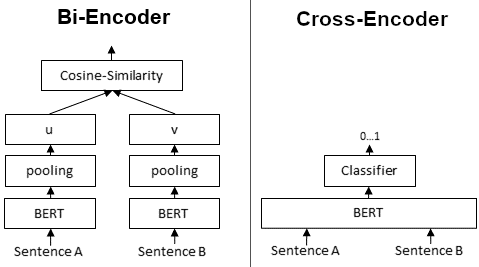

<br>

In [63]:
# Initialize the cross encoder model with the 'ms-marco-MiniLM-L-6-v2'
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [67]:
#Input (query,response) pairs of each of the top 10 response received from the semantic search to cross encoder

# Prepare inputs for cross-encoder prediction by pairing each query with each response from the results DataFrame.
cross_input=[[query,response]for response in results_df_e["Documents"]]

#predict Cross-encoder scores for each query-response pair.
cross_rerank_scores=cross_encoder.predict(cross_input)

#display the cross-encoder Scores
cross_rerank_scores

array([1.6360493, 7.6009855, 6.442712 , 7.4153543, 7.296981 ],
      dtype=float32)

In [69]:
# Store the reranked scores in the results DataFrame under the column 'Reranked_scores'.
results_df_e['Reranked_scores'] = cross_rerank_scores

# Display the updated results DataFrame.
results_df_e

IDs                                          Documents  \
0   9864037  Pink solid Kurta with Trousers Kurta design: S...   
1  11434632  Red embroidered kurta with trousers and dupatt...   
2  12834498  Pink, golden and red printed straight dyed kur...   
3   3084524  Red and golden printed A-line kurta, has a man...   
4  18929396  Red and golden printed A-line kurta with slits...   

             Distances                                          Metadatas  \
0  0.21649488806724548  {'Price_INR': 1849.0, 'Brand': 'Vishudh', 'Pro...   
1  0.20753318071365356  {'Brand': 'Meeranshi', 'Price_INR': 2199.0, 'P...   
2   0.2112622708082199  {'Product_attributes': "{'Body Shape ID': '443...   
3  0.21598178148269653  {'Price_INR': 5899.0, 'Product_type': 'Kurta, ...   
4  0.20943519473075867  {'Brand': 'Vishudh', 'Product_attributes': "{'...   

   Reranked_scores  
0         1.636049  
1         7.600986  
2         6.442712  
3         7.415354  
4         7.296981

In [72]:
results_df_e["Documents"].iloc[1]

'Red embroidered kurta with trousers and dupatta Red straight calf length kurta, has a round neck, three-quarter sleeves, side slits Red solid trousers, has partially elasticated waistband, slip-on closure Red solid dupatta, has taping borderThe model (height 5\'8") is wearing a size SKurta fabric: silk blend Bottom fabric: cotton blend Dupatta fabric: organza Dry-clean Inddus Women Red Embroidered Kurta with Trousers & Dupatta'

In [73]:
#sort the results DataFrame by Reranked_scores in descending order and select the top3 entries.

top_3_rerank=results_df_e.sort_values(by='Reranked_scores',ascending=False)[:3]

top_3_rerank

IDs                                          Documents  \
1  11434632  Red embroidered kurta with trousers and dupatt...   
3   3084524  Red and golden printed A-line kurta, has a man...   
4  18929396  Red and golden printed A-line kurta with slits...   

             Distances                                          Metadatas  \
1  0.20753318071365356  {'Brand': 'Meeranshi', 'Price_INR': 2199.0, 'P...   
3  0.21598178148269653  {'Price_INR': 5899.0, 'Product_type': 'Kurta, ...   
4  0.20943519473075867  {'Brand': 'Vishudh', 'Product_attributes': "{'...   

   Reranked_scores  
1         7.600986  
3         7.415354  
4         7.296981

<a id='layer2_all'></a>
### <p style="color: #333333; background-color: #ffc0cb;"> Semantic Search with Re-ranking </p>

In [ ]:
def SemanticSearchWithReranking(query=None, top_n=5, imshow=True):
    # If query is not provided, prompt the user to enter a query
    if query is None:
        query = input()

    print()
    print('-'*30)
    print('Query : ', query)
    print('-'*30)
    print()

    #Query the main or cache collection based on the input query 
    query_result=query_from_db_or_cache_collection(query)

    #Prepare inputs for cross-encoder prediction and predict rerank scores
    cross_inputs=[[query,response]for response in query_result["Documents"]]

    #predict Cross-encoder scores for each query-response pair.
    cross_rerank_scores=cross_encoder.predict(cross_inputs)

   # Store the reranked scores in the results DataFrame under the column 'Reranked_scores'.
    query_result['Reranked_scores'] = cross_rerank_scores

    # Select top n reranked entries
    top_n_rerank=query_result.sort_values(by='Reranked_scores',ascending=False)[:top_n]
    
    if imshow is True:
      # Display images corresponding to the IDs side by side
      num_images = len(top_n_rerank['IDs'])
      fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

      # Set the title of the plot as the user query
      fig.suptitle(f"Top {top_n} Search Layer", fontsize=16)

      for i, item_id in enumerate(top_n_rerank['IDs']):
          # Construct the path to the image file
          image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')
          #print(image_path)

          # Check if the image file exists
          if os.path.exists(image_path):
              # Open and display the image
              img = Image.open(image_path)
              axes[i].imshow(img)
              axes[i].axis('off')
              axes[i].set_title(f"ID: {item_id}")
          else:
              print(f"Image not found for item ID: {item_id}")

      plt.tight_layout()
      plt.show()

    return top_n_rerank


  


------------------------------
Query :  yellow kurta
------------------------------

[INFO]:Found in cache!
data/Images/11349574.jpg
data/Images/12831164.jpg
data/Images/13791594.jpg
data/Images/13527954.jpg
data/Images/13932854.jpg


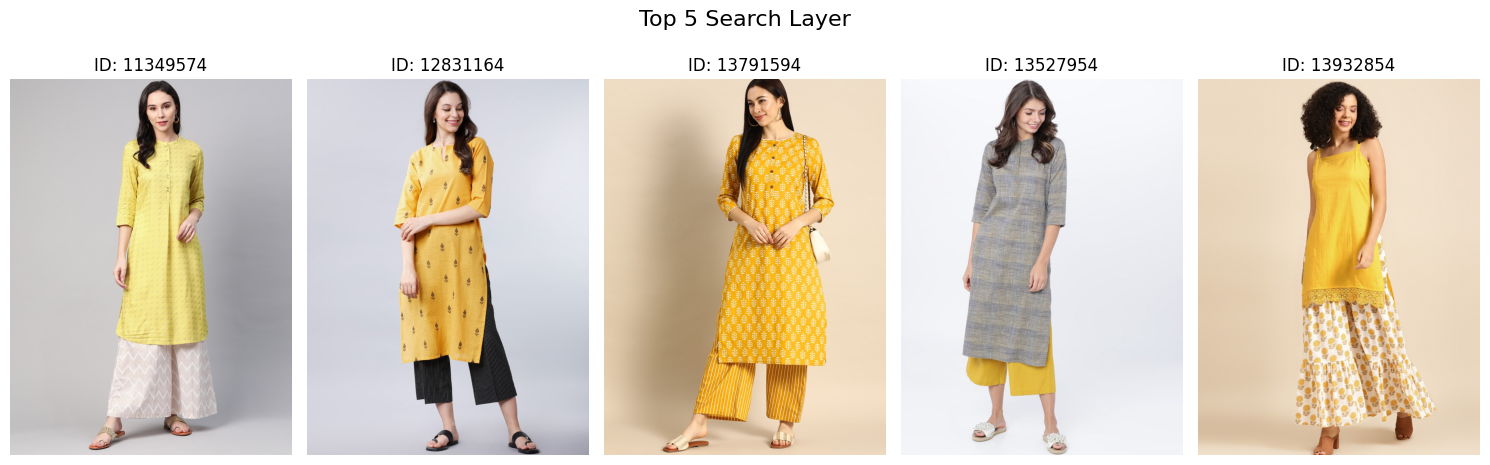

IDs                                          Documents  \
2  11349574  Yellow and off-white solid kurta with sharara ...   
1  12831164  Yellow and Golden printed straight kurta, has ...   
4  13791594  Yellow and white printed kurta with palazzos Y...   
0  13527954  Yellow and Black printed straight kurta, has a...   
3  13932854  Grey and Yellow striped straight kurta, has a ...   

             Distances                                          Metadatas  \
2  0.17849129438400269  {'Product_type': 'Kurta', 'Description': 'Yell...   
1   0.1983247697353363  {'RatingCount': 7012.0, 'Brand': 'Anouk', 'Pri...   
4  0.19126395881175995  {'Name': 'Vishudh Women Grey & Yellow Striped ...   
0  0.19384022057056427  {'Product_id': 11349574, 'Rating': 4.333333333...   
3  0.18727174401283264  {'Colour': 'Yellow', 'Price_INR': 3198.0, 'Des...   

   Reranked_scores  
2         7.915196  
1         7.752580  
4         7.709883  
0         7.484389  
3         7.297157

In [182]:
# An example semantic search
ranking=SemanticSearchWithReranking('yellow kurta')
ranking

---

<a id='layer3'></a>
## Layer 3 : Generative Search

Now that we have the final top semantic search results with reranking, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query rather than returning the stored result.

In [178]:
#generate a response using gpt-3.5

def generate_response(query, top_rag):


   messages = [
                {"role": "system", "content":  "You are a fashion expert who can showcase a product in such a way that the user gets satisfied."},
                {"role": "user", "content": f"""You are a fashion expert who can showcase a product in such a way that the user gets satisfied.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of fashion products database in the dataframe. These search results are essentially a product that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual description of the product.

                                                Use the documents in '{top_rag}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return product details.
                                                Also ,Use the data from 'Attributes' and provide an answer related to the query '{query}'

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If you can't provide the complete answer, please provide a disclaimer.
                                                4. Do not use keywords which are similar to 'database', 'results', 'search'
                                                5. Do not start with a welcome note and do not close the conversation with a follow up statement or question else you will be heavily penalized.

                                                The generated response should answer the query directly addressing the user and avoiding additional information.
                                                If you think that the query is not relevant to the document, reply with a best possible response.
                                                Provide the final simple, clear and natural response in a well-formatted and easily readable text.
                                                """},
              ]

   response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )
   
   return response.choices[0].message.content.split('\n')


In [162]:
ranking=ranking.reset_index()
ranking

index       IDs                                          Documents  \
0      4  13932854  Yellow and off-white solid kurta with sharara ...   
1      1  11349574  Yellow and Golden printed straight kurta, has ...   
2      3  13791594  Yellow and white printed kurta with palazzos Y...   
3      0  12831164  Yellow and Black printed straight kurta, has a...   
4      2  13527954  Grey and Yellow striped straight kurta, has a ...   

                                           Metadatas  Distances  \
0  {'Colour': 'Yellow', 'Price_INR': 3198.0, 'Des...   0.198325   
1  {'Product_id': 11349574, 'Rating': 4.333333333...   0.187272   
2  {'RatingCount': 7012.0, 'Brand': 'Anouk', 'Pri...   0.193840   
3  {'Product_type': 'Kurta', 'Description': 'Yell...   0.178491   
4  {'Name': 'Vishudh Women Grey & Yellow Striped ...   0.191264   

   Reranked_scores  
0         7.915196  
1         7.752580  
2         7.709883  
3         7.484389  
4         7.297157

In [164]:
ranking = ranking.reset_index(drop=True)

In [165]:
ranking

index       IDs                                          Documents  \
0      4  13932854  Yellow and off-white solid kurta with sharara ...   
1      1  11349574  Yellow and Golden printed straight kurta, has ...   
2      3  13791594  Yellow and white printed kurta with palazzos Y...   
3      0  12831164  Yellow and Black printed straight kurta, has a...   
4      2  13527954  Grey and Yellow striped straight kurta, has a ...   

                                           Metadatas  Distances  \
0  {'Colour': 'Yellow', 'Price_INR': 3198.0, 'Des...   0.198325   
1  {'Product_id': 11349574, 'Rating': 4.333333333...   0.187272   
2  {'RatingCount': 7012.0, 'Brand': 'Anouk', 'Pri...   0.193840   
3  {'Product_type': 'Kurta', 'Description': 'Yell...   0.178491   
4  {'Name': 'Vishudh Women Grey & Yellow Striped ...   0.191264   

   Reranked_scores  
0         7.915196  
1         7.752580  
2         7.709883  
3         7.484389  
4         7.297157

In [167]:
for index,result in ranking.iterrows():
    if index==0:
        response=generate_response("yellow kurta",result[['Documents']])
        



In [171]:
response.choices[0].message.content.split('\n')

['The yellow kurta featured in our collection is a vibrant and stylish choice for any occasion. The off-white accents add a touch of elegance to the ensemble. The set includes a sharara to complete the look, making it a versatile and fashionable outfit. Embrace this yellow and off-white solid kurta with sharara for a chic and trendy appearance.',
 '',
 'For product details:',
 '- Type: Yellow and off-white solid kurta with sharara',
 '- Details: This ensemble exudes sophistication and charm with its color combination and design. The sharara adds a contemporary flair to the traditional kurta, making it a standout choice.',
 '',
 'If you are looking for a trendy yet classic outfit, this yellow kurta set is a perfect option that combines traditional elements with modern style.']

In [183]:
import ast 
from IPython.display import display,HTML

def wrap_text(text,line_length=15):
    words=text.split()
    wrapped_text = '\n'.join([' '.join(words[i:i+line_length]) for i in range(0, len(words), line_length)])
    return wrapped_text

# Display an image corresponding to a product result from the dataframe.
def display_image(result_df):
    # Extract metadata from the input result
    metadata_string = result_df['Metadatas']

    # Convert metadata string to dictionary and extract image number
    try:
        metadata_dict = ast.literal_eval(metadata_string)
        imgNo_string = str(metadata_dict['Product_id'])
    except ValueError:
        imgNo_string = str(metadata_string['Product_id'])

    # Construct path to the image
    img_path = os.path.join(images_folder_path , imgNo_string + ".jpg")


    # Display the image
    image = Image.open(img_path).resize((240, 300))
    display(image)

def print_response_and_display_image(result_df, response, result_text = "Response:"):
    # Prepare the response text
    response_text = ' '.join(response)  # Combine list of strings into one string
    wrapped_text = wrap_text(response_text)

            # Display the text on the right using HTML
    html_content = f"""
        <div style="padding-left: 2px;">
            <h3>{result_text}</h3>
            <p style="font-size: 14px; line-height: 1.5;">{wrapped_text}</p>
             <p style="font-size: 14px; line-height: 1.5;">The suggested product looks like</p>
        </div>
        """
    display(HTML(html_content))

    # Display the image of the suggested product
    display_image(result_df)

In [ ]:
# Perform generative search by combining semantic search with reranking and generating a response.
def GenerativeSearch(query=None):
    # If query is not provided, prompt the user to input a query
    if query is None:
        query = input()

    # Perform semantic search with reranking to retrieve the top 5 most relevant results
    semantic_search_df = SemanticSearchWithReranking(query, top_n=5, imshow = False)
    # Reset the index for proper iteration
    semantic_search_df = semantic_search_df.reset_index()

    for index, result in semantic_search_df.iterrows():
        if index == 0:
            # Generate a response based on the query and retrieved information
            response = generate_response(query, result[['Documents']])
            print_response_and_display_image(result_df=result, response=response, result_text="Top product")
        else:
            # Check if the current result is close to the previous result
            if abs(previous_rank_score - result['Reranked_scores']) <= 0.5:
                # Generate a response based on the query and retrieved information
                response = generate_response(query, result[['Documents']])
                print_response_and_display_image(result_df=result, response=response, result_text="Similar product")
            # If not close enough, break the loop and stop suggesting similar products
            else:
                break
        # Store the current rerank score to compare in the next cycle
        previous_rank_score = result['Reranked_scores']


------------------------------
Query :  white kurta
------------------------------

[INFO]: Not Found in cache. Found in main collection.
data/Images/9815193.jpg
data/Images/7760039.jpg
data/Images/3077373.jpg
data/Images/9702305.jpg
data/Images/11074238.jpg


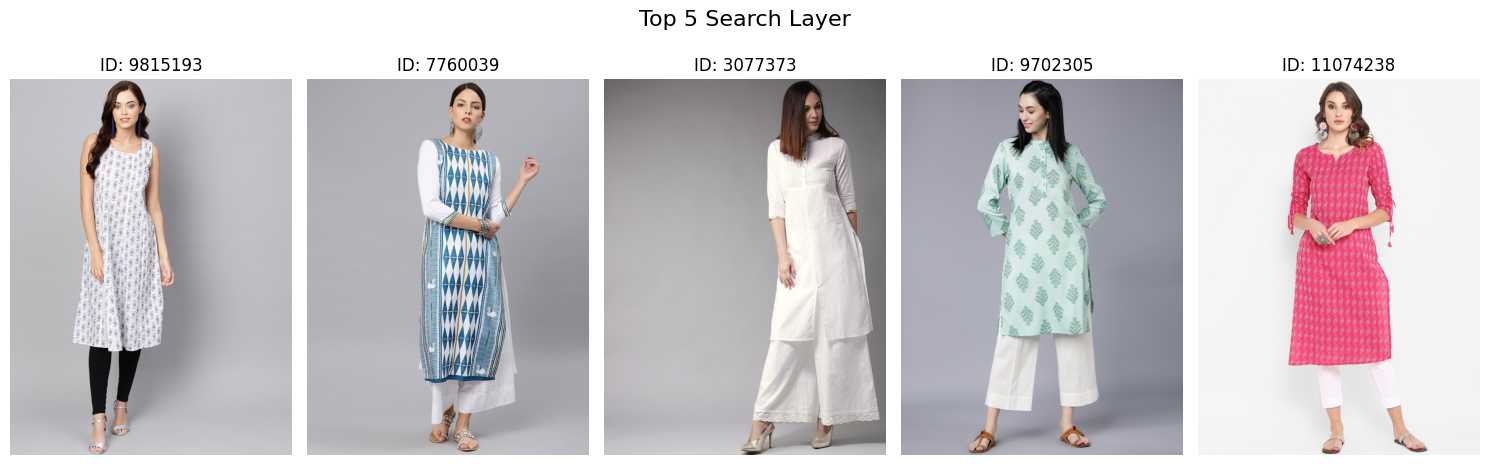

IDs                                          Documents  \
0   9815193  White and blue printed A-line kurta, has a rou...   
1   7760039  White and blue printed straight kurta, has a r...   
3   3077373  White solid straight kurta, has a mandarin col...   
4   9702305  Blue and white printed straight kurta, has a m...   
2  11074238  Pink and White printed straight kurta, has a r...   

                                           Metadatas  Distances  \
0  {'Price_INR': 1699.0, 'Colour': 'White', 'Bran...   0.215657   
1  {'RatingCount': 1650.0, 'Description': 'White ...   0.217490   
3  {'Colour': 'White', 'Product_id': 3077373, 'Na...   0.219096   
4  {'Product_id': 9702305, 'Name': 'Vishudh Women...   0.221713   
2  {'Colour': 'Pink', 'Name': 'Janasya Women Pink...   0.218317   

   Reranked_scores  
0         7.251154  
1         7.228898  
3         7.186256  
4         6.853330  
2         6.634296

In [188]:
SemanticSearchWithReranking("white kurta")


------------------------------
Query :  Maroon blazer for casual occasion from Van Heusen
------------------------------

[INFO]:Found in cache!


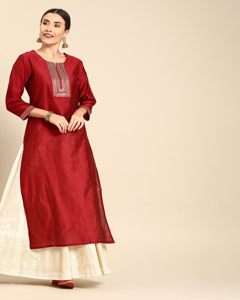

In [ ]:
# An example generative search
GenerativeSearch('Maroon blazer for casual occasion from Van Heusen')


------------------------------
Query :  I'm looking for a denim jacket that includes at least four pockets. Ideally, it should be versatile and functional, fitting well with different outfits.
------------------------------

[INFO]: Not Found in cache. Found in main collection.
data/Images/13238184.jpg
data/Images/16156728.jpg
data/Images/11157052.jpg
data/Images/14346054.jpg
data/Images/13921184.jpg


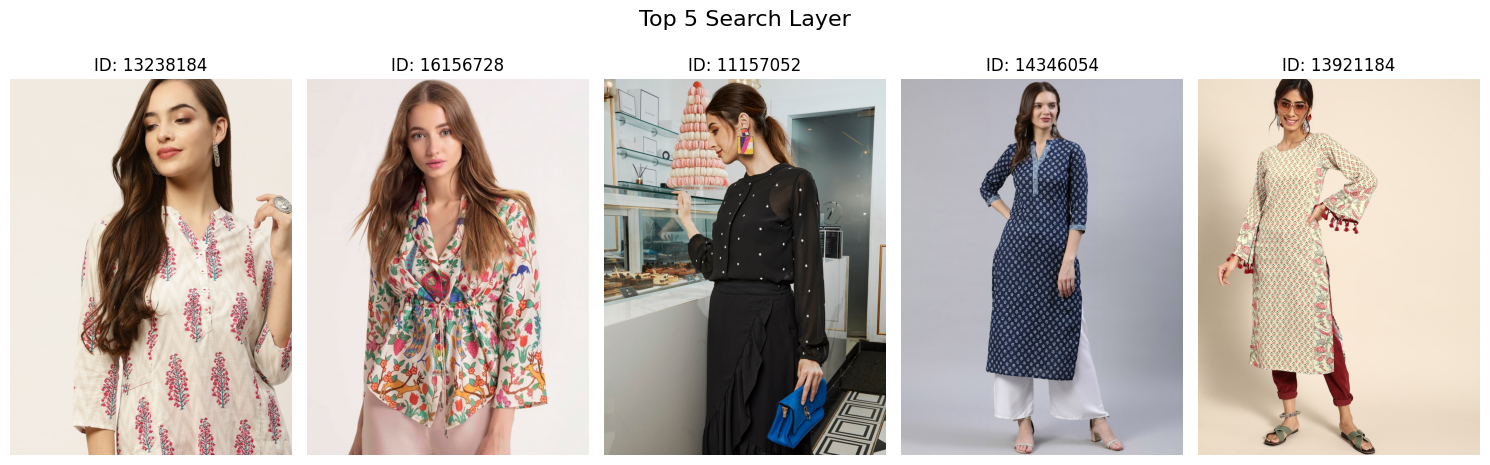

IDs                                          Documents  \
2  13238184  Colour: White and pink Ethnic motifs print Man...   
0  16156728  Cream-coloured regular Button-down lapel shirt...   
4  11157052  Black and white embroidered woven regular top,...   
1  14346054  Colour: navy blue&nbsp; Ethnic motifs printed ...   
3  13921184  Ideal for warm weather dressing, this kurta en...   

                                           Metadatas  Distances  \
2  {'Product_attributes': '{'Body Shape ID': '424...   0.449735   
0  {'Price_INR': 2449.0, 'Name': 'SHAYE Cream-Col...   0.427658   
4  {'Name': 'QUIERO Black & White Embroidered Top...   0.450689   
1  {'Product_id': 14346054, 'Rating': 4.326153846...   0.446724   
3  {'Price_INR': 1498.0, 'RatingCount': 26.0, 'Ra...   0.450065   

   Reranked_scores  
2        -6.786127  
0        -8.734695  
4        -9.266521  
1        -9.813099  
3        -9.960409

In [190]:
SemanticSearchWithReranking("I'm looking for a denim jacket that includes at least four pockets. Ideally, it should be versatile and functional, fitting well with different outfits.")


------------------------------
Query :  Salwar set in pink color
------------------------------

[INFO]: Not Found in cache. Found in main collection.
data/Images/17487126.jpg
data/Images/8348995.jpg
data/Images/17172164.jpg
data/Images/13747928.jpg
data/Images/12711000.jpg


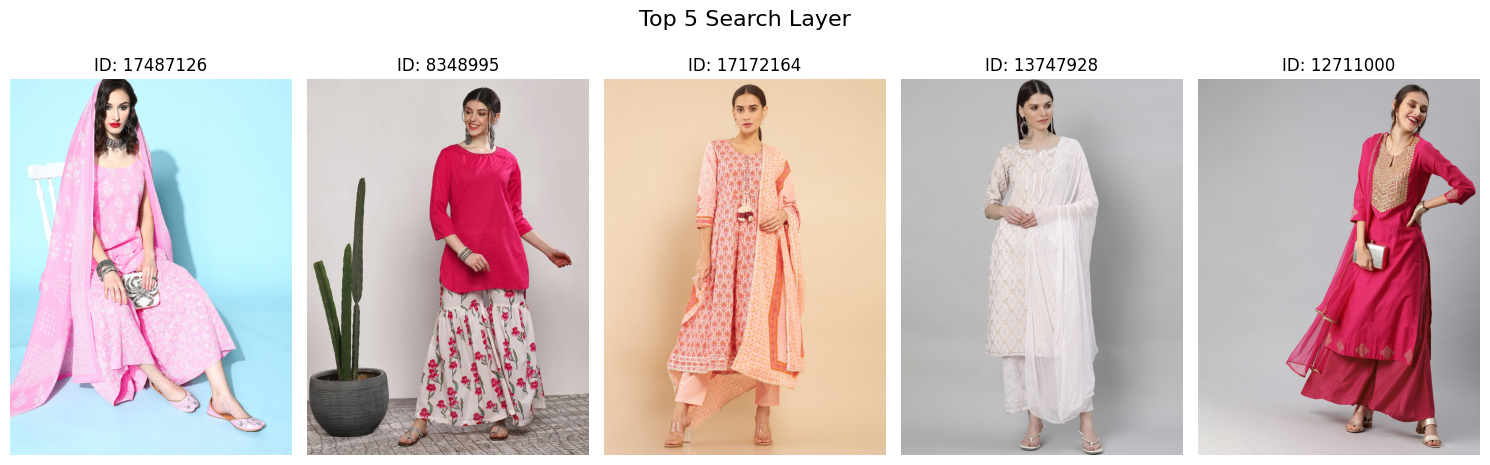

IDs                                          Documents  \
1  17487126  Our 3-piece pink floral print cotton suit set ...   
4   8348995  Pink and white (Brand colour: Fuchsia) printed...   
3  17172164  Pink printed Kurta with Trousers with dupatta ...   
0  13747928  Pink printed kurta with palazzos and dupatta P...   
2  12711000  Pink embroidered kurta with palazzos and dupat...   

                                           Metadatas  Distances  \
1  {'Price_INR': 2999.0, 'RatingCount': 17.0, 'Na...   0.229211   
4  {'Product_id': 8348995, 'RatingCount': 417.0, ...   0.234964   
3  {'Price_INR': 3498.0, 'Brand': 'Soch', 'Rating...   0.232150   
0  {'Product_id': 13747928, 'Colour': 'Pink', 'Pr...   0.226951   
2  {'Colour': 'Pink', 'Product_attributes': '{'Ad...   0.230675   

   Reranked_scores  
1        -3.645391  
4        -6.737332  
3        -6.865282  
0        -9.022469  
2        -9.216747

In [191]:
SemanticSearchWithReranking("Salwar set in pink color")

In [ ]:
def main():
    #print("[INFO] Loading data...")
    #fashion_df = load_and_process_data()

    print("[INFO] Initializing ChromaDB...")
    fashion_collection = init_chroma_collection()

    #print("[INFO] Populating ChromaDB (first 1000 records)...")
    #populate_chroma(fashion_collection, fashion_df)
    # Example query

    query = "red dress with floral pattern"
    print(f"[INFO] Querying for: '{query}'")
    results = fashion_collection.query(query_texts=[query], n_results=5)

    # Convert raw results to DataFrame for reranking
    result_dict = {
        "IDs": results['ids'][0],
        "Documents": results['documents'][0],
        "Metadatas": results['metadatas'][0],
        "Distances": results['distances'][0]
    }
    import pandas as pd
    query_result_df = pd.DataFrame(result_dict)

    rerank_and_display(query_result_df, query)